#**Explorar a biblioteca MLIB do PySpark**

**prof: Sergio Assuncao Monteiro, DSc**

lattes: http://lattes.cnpq.br/9489191035734025

# **(0.1) Pre-Requisitos**

In [55]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

# **(0.2) Configuracao das Variaveis de Ambiente**

In [56]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

# **01: Árvore de Classificação**

**Iniciar Spark**

In [57]:
import findspark
findspark.init()


**Importar os pacotes**

In [58]:
import findspark
findspark.init()

from pyspark import SparkFiles
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

**Iniciar a sessão Spark**

In [59]:
spark = SparkSession.builder.appName("Decision Tree Model").getOrCreate()

**Carregar o conjunto de dados**

In [60]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/Iris.csv"
spark.sparkContext.addFile(url)

df = spark.read.csv(SparkFiles.get("Iris.csv"), header=True, inferSchema=True)
df.show(5)

+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 5 rows



**Preparar os dados**

In [61]:
# Convert the categorical labels in the 'Species' column to numerical values
label_indexer = StringIndexer(inputCol="Species", outputCol="label")
data = label_indexer.fit(df).transform(df)

# Assemble the feature columns into a single vector column
assembler = VectorAssembler(inputCols=["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"], outputCol="features")
data = assembler.transform(data)

# Split data into training and testing sets
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

**Treinar o modelo de árvore de decisão**

In [62]:
dt_classifier = DecisionTreeClassifier(labelCol="label", featuresCol="features")

model = dt_classifier.fit(train_data)

**Avaliar a qualidade da classificação com os dados de tes**

In [63]:
predictions = model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.2f}")

Test Accuracy: 0.92


 **Analisar a Importância de Cada Característica para Classificação**

In [64]:
feature_importance = model.featureImportances.toArray()

# Show feature importance
for i, column in enumerate(assembler.getInputCols()):
    print(f"Feature '{column}': {feature_importance[i]:.2f}")

Feature 'SepalLengthCm': 0.00
Feature 'SepalWidthCm': 0.02
Feature 'PetalLengthCm': 0.53
Feature 'PetalWidthCm': 0.45


**Visualizar a Árvore de Decisão**

In [65]:
print(model.toDebugString)

DecisionTreeClassificationModel: uid=DecisionTreeClassifier_67c861402ea3, depth=4, numNodes=13, numClasses=3, numFeatures=4
  If (feature 2 <= 2.45)
   Predict: 0.0
  Else (feature 2 > 2.45)
   If (feature 3 <= 1.65)
    If (feature 2 <= 4.95)
     Predict: 1.0
    Else (feature 2 > 4.95)
     If (feature 3 <= 1.55)
      Predict: 2.0
     Else (feature 3 > 1.55)
      Predict: 1.0
   Else (feature 3 > 1.65)
    If (feature 2 <= 4.85)
     If (feature 1 <= 3.05)
      Predict: 2.0
     Else (feature 1 > 3.05)
      Predict: 1.0
    Else (feature 2 > 4.85)
     Predict: 2.0



**Salvar e  carregar o modelo (opcional)**

In [66]:
# Save the model
model.save("Dtree_model")

# Load the model
from pyspark.ml.classification import DecisionTreeClassificationModel
loaded_model = DecisionTreeClassificationModel.load("Dtree_model")

Py4JJavaError: ignored

**Fechar a Sessão Spark**

In [86]:
spark.stop()

# **02: Clusterização**

**Iniciar a Sessão Spark**

In [87]:
import findspark
findspark.init()
from pyspark import SparkFiles
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
import pandas as pd

spark = SparkSession.builder.appName("Mastering K-means Clustering with PySpark MLlib").getOrCreate()

**Carregar os dados**

In [88]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/Iris.csv"
spark.sparkContext.addFile(url)

df = spark.read.csv(SparkFiles.get("Iris.csv"), header=True, inferSchema=True)
df.show(5)

+---+-------------+------------+-------------+------------+-----------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|
+---+-------------+------------+-------------+------------+-----------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|
+---+-------------+------------+-------------+------------+-----------+
only showing top 5 rows



In [89]:
#Print schema
df.printSchema()


root
 |-- Id: integer (nullable = true)
 |-- SepalLengthCm: double (nullable = true)
 |-- SepalWidthCm: double (nullable = true)
 |-- PetalLengthCm: double (nullable = true)
 |-- PetalWidthCm: double (nullable = true)
 |-- Species: string (nullable = true)



**Processar Dados**

In [90]:
# Assembling features into a single column
assembler = VectorAssembler(inputCols=["SepalLengthCm", "SepalWidthCm", "PetalLengthCm", "PetalWidthCm"], outputCol="features")
data_df = assembler.transform(df)

# Scaling the features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")
scaler_model = scaler.fit(data_df)
data_df = scaler_model.transform(data_df)

data_df.show(5)

+---+-------------+------------+-------------+------------+-----------+-----------------+--------------------+
| Id|SepalLengthCm|SepalWidthCm|PetalLengthCm|PetalWidthCm|    Species|         features|     scaled_features|
+---+-------------+------------+-------------+------------+-----------+-----------------+--------------------+
|  1|          5.1|         3.5|          1.4|         0.2|Iris-setosa|[5.1,3.5,1.4,0.2]|[6.15892840883878...|
|  2|          4.9|         3.0|          1.4|         0.2|Iris-setosa|[4.9,3.0,1.4,0.2]|[5.9174018045706,...|
|  3|          4.7|         3.2|          1.3|         0.2|Iris-setosa|[4.7,3.2,1.3,0.2]|[5.67587520030241...|
|  4|          4.6|         3.1|          1.5|         0.2|Iris-setosa|[4.6,3.1,1.5,0.2]|[5.55511189816831...|
|  5|          5.0|         3.6|          1.4|         0.2|Iris-setosa|[5.0,3.6,1.4,0.2]|[6.03816510670469...|
+---+-------------+------------+-------------+------------+-----------+-----------------+--------------------+
o

**Encontrar a Quantidade Ótima de Clusters**

In [91]:
# Computing WSSSE for K values from 2 to 8
wssse_values =[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='scaled_features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

for i in range(2,8):
    KMeans_mod = KMeans(featuresCol='scaled_features', k=i)
    KMeans_fit = KMeans_mod.fit(data_df)
    output = KMeans_fit.transform(data_df)
    score = evaluator.evaluate(output)
    wssse_values.append(score)
    print("Silhouette Score:",score)

Silhouette Score: 0.7714149126311811
Silhouette Score: 0.6535875501205959
Silhouette Score: 0.5879625797757644
Silhouette Score: 0.5363148259763028
Silhouette Score: 0.5252242150380523
Silhouette Score: 0.5036922541166375


**Imprimir o gráfico**

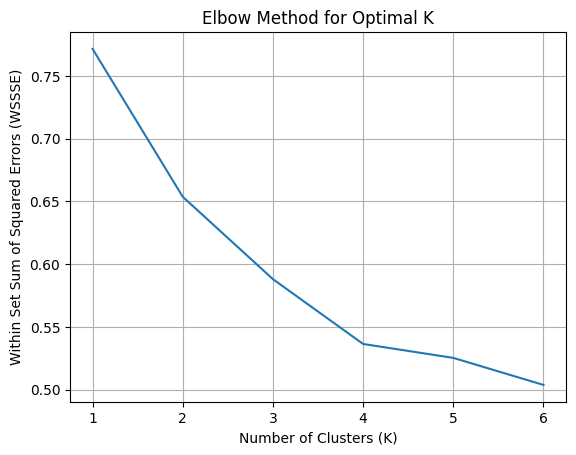

In [92]:
# Plotting WSSSE values
plt.plot(range(1, 7), wssse_values)
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within Set Sum of Squared Errors (WSSSE)')
plt.title('Elbow Method for Optimal K')
plt.grid()
plt.show()

**Executar o K-Means**

In [93]:
# Define the K-means clustering model
kmeans = KMeans(k=4, featuresCol="scaled_features", predictionCol="cluster")
kmeans_model = kmeans.fit(data_df)

# Assigning the data points to clusters
clustered_data = kmeans_model.transform(data_df)

**Avaliar o modelo**

In [94]:
output = KMeans_fit.transform(data_df)
wssse = evaluator.evaluate(output)
print(f"Within Set Sum of Squared Errors (WSSSE) = {wssse}")

Within Set Sum of Squared Errors (WSSSE) = 0.5036922541166375


**Visualizar os Resultados**

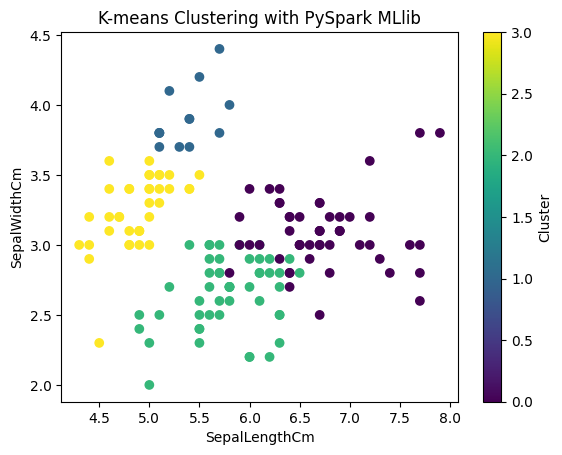

In [95]:
# Converting to Pandas DataFrame
clustered_data_pd = clustered_data.toPandas()

# Visualizing the results
plt.scatter(clustered_data_pd["SepalLengthCm"], clustered_data_pd["SepalWidthCm"], c=clustered_data_pd["cluster"], cmap='viridis')
plt.xlabel("SepalLengthCm")
plt.ylabel("SepalWidthCm")
plt.title("K-means Clustering with PySpark MLlib")
plt.colorbar().set_label("Cluster")
plt.show()

**Fechar a Sessão Spark**

In [96]:
spark.stop()

# **03: Regressão Linear**

**Importar e iniciar Spark**

In [97]:
import findspark
findspark.init()

from pyspark.sql import SparkSession
from pyspark import SparkFiles
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import RegressionEvaluator

spark = SparkSession.builder \
    .appName("Linear Regression with PySpark MLlib") \
    .getOrCreate()

**Carregar os dados**

In [98]:
url = "https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv"
spark.sparkContext.addFile(url)

data = spark.read.csv(SparkFiles.get("BostonHousing.csv"), header=True, inferSchema=True)
data.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



**Preparar os dados**

In [99]:
assembler = VectorAssembler(
    inputCols=["crim", "zn", "indus", "chas", "nox", "rm", "age", "dis", "rad", "tax", "ptratio", "b", "lstat"],
    outputCol="features")

data = assembler.transform(data)
final_data = data.select("features", "medv")

train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

**Construir o modelos de Regressão Linear**

In [100]:
lr = LinearRegression(featuresCol="features", labelCol="medv", predictionCol="predicted_medv")
lr_model = lr.fit(train_data)

**Realizar predições e avaliar o modelo**

In [101]:
predictions = lr_model.transform(test_data)

evaluator = RegressionEvaluator(labelCol="medv", predictionCol="predicted_medv", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data: {:.3f}".format(rmse))

evaluator_r2 = RegressionEvaluator(labelCol="medv", predictionCol="predicted_medv", metricName="r2")
r2 = evaluator_r2.evaluate(predictions)
print("R-squared (R2) on test data: {:.3f}".format(r2))

Root Mean Squared Error (RMSE) on test data: 4.672
R-squared (R2) on test data: 0.793


**Analisar o modelo**

In [102]:
coefficients = lr_model.coefficients
intercept = lr_model.intercept

print("Coefficients: ", coefficients)
print("Intercept: {:.3f}".format(intercept))

Coefficients:  [-0.1136220372940893,0.04890918693405423,0.02379542898673218,2.8017719987351315,-18.41542454118947,3.5158797633119243,0.005211682161471423,-1.416383072353979,0.33176693159370374,-0.013607893704163855,-0.9534143338408103,0.008602677392853194,-0.5195035312476691]
Intercept: 38.617


**Analisar a importância da característica**

In [103]:
feature_importance = sorted(list(zip(data.columns[:-1], map(abs, coefficients))), key=lambda x: x[1], reverse=True)

print("Feature Importance:")
for feature, importance in feature_importance:
    print("  {}: {:.3f}".format(feature, importance))

Feature Importance:
  nox: 18.415
  rm: 3.516
  chas: 2.802
  dis: 1.416
  ptratio: 0.953
  lstat: 0.520
  rad: 0.332
  crim: 0.114
  zn: 0.049
  indus: 0.024
  tax: 0.014
  b: 0.009
  age: 0.005


**Salvar e carregar o modelo**

In [104]:
# Save the model
lr_model.save("lr_model")

# Load the model
from pyspark.ml.regression import LinearRegressionModel
loaded_model = LinearRegressionModel.load("lr_model")

**Fechar a Sessão Spark**

In [105]:
spark.stop()